# 0) Import des Librairies

---



In [ ]:
#pip install prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [2]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\1233923705.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [ ]:
import zipfile

In [5]:

chemin_zip = './Data/donnee_ts.zip'
dossier_extraction = './Data'

with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
    zip_ref.extractall(dossier_extraction)

In [109]:
df=pd.read_csv('./Data/donnee_ts.csv')
del df["Unnamed: 0"]

C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\1678533545.py:1: DtypeWarning:

Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.



In [127]:
df['code_station'] = df['code_station'].astype(str)

# Stations

In [6]:
a=df.groupby(["libelle_departement", "code_cours_eau","code_station"]).agg({"resultat_obs_elab": "count" })

In [128]:
df["code_station"].nunique()

710

In [129]:
station=df["code_station"].unique()

On a 711 stations à étudier. 
Nous allons commencer par nous focaliser sur celle avec le plus de data

In [16]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)
nb_values

code_station
E642601001    6862
A325021001    6862
B532201001    6862
H224000501    6862
A243003001    6862
              ... 
B423000102      27
A664031001      27
1221000101      24
B700001002      13
F400000101       6
Name: resultat_obs_elab, Length: 711, dtype: int64

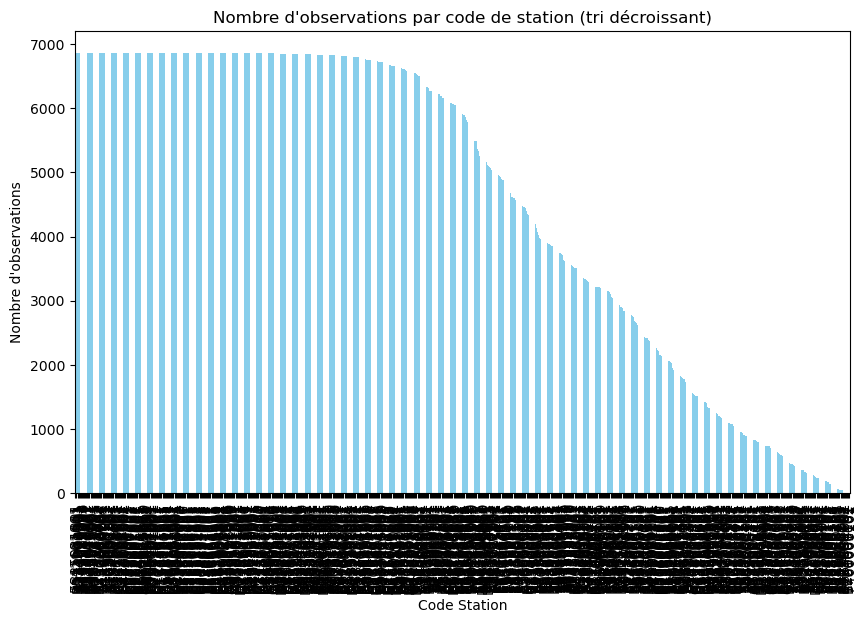

In [10]:


nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
nb_values.plot(kind='bar', color='skyblue')

plt.xlabel('Code Station')
plt.ylabel('Nombre d\'observations')
plt.title('Nombre d\'observations par code de station (tri décroissant)')

plt.show()


In [33]:
# nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
# big_station=nb_values[nb_values>5000]
# df = df[df["code_station"].isin(big_station.index)]

In [17]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
station=nb_values[nb_values>5000]

In [18]:
station.index

Index([  2501000101,   2503000101,   2521000102,   5041000101,   5221000101,
       '6020000101', '8032000101', '9104000101', 'A022020001', 'A041030001',
       ...
       'H514261001', 'H514262001', 'H515301001', 'H517201001', 'H517311001',
       'H520101003', 'H520421001', 'H521331001', 'H522431001', 'H524301001'],
      dtype='object', name='code_station', length=387)

# Fonctions de visualisaiton 

Pour visualiser les données

In [5]:
def visu(ts):
    nom_station = ts["libelle_station"].iloc[0]
    
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])
    
    # Tracé d'un graphique temporel
    plt.figure(figsize=(15, 6))
    plt.plot(ts["date_obs_elab"], ts["resultat_obs_elab"], linewidth=3)
    plt.title(f'Stations {nom_station}')
    plt.show()

    # Histogramme
    fig = px.histogram(ts, x="resultat_obs_elab")
    fig.update_layout(title=f'Stations {nom_station}')
    fig.show()  

    # Box plot mensuel
    ts['Mois'] = ts['date_obs_elab'].dt.month_name()
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Mois', y='resultat_obs_elab', data=ts)
    plt.xlabel('Mois')
    plt.ylabel('Résultat Observation Elab')
    plt.title(f'Stations {nom_station}')
    plt.xticks(rotation=45)
    plt.show()



# Fonction de mise en forme

In [6]:
def mise_en_forme(ts):
    ts=ts[['date_obs_elab','resultat_obs_elab']]
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])

    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]
   
    train_r=train.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})

    test_r=test.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})
    return train_r, test_r

# Modele

Création du modèle, et on utilise le modèle sur la base test

In [7]:
# def model(train_r,test_r):
#     model = Prophet(
#     yearly_seasonality=12,  # Increase the number of Fourier terms
#     seasonality_prior_scale=0.8,  # Adjust the seasonality prior scale
#     )

#     model.fit(train_r)  
#     test_fcst = model.predict(df=test_r)

#     future_dates = model.make_future_dataframe(periods=6*12*30, freq='D')  
#     forecast = model.predict(future_dates)
#     return (model, test_fcst,forecast)

In [258]:
def model(train_r, test_r):
    model = Prophet(
        yearly_seasonality=12,  
        seasonality_prior_scale=0.8,
        changepoint_prior_scale=0.05,  # Ajuster le changepoint_prior_scale pour augmenter la sensibilité aux changements de tendance
    )
    model.uncertainty_samples = 1000  # Augmenter le nombre d'échantillons d'incertitude


    model.fit(train_r)
    
    test_fcst = model.predict(df=test_r)

    start_date = test_r['ds'].min()
    end_date = datetime.strptime("2024-12-31", "%Y-%m-%d")
    days_difference = (end_date - start_date).days

    future_dates = model.make_future_dataframe(periods=days_difference, freq='D')
    #future_dates = future_dates[future_dates['ds'].dt.year >= 2020]

    forecast = model.predict(future_dates)

    factor = 1.8  #  augmenter l'écart-type 
    forecast['yhat'] = forecast['yhat'] * factor  - forecast['trend']
    #forecast['yhat'] = forecast['yhat'] - forecast['trend'] enlever la trend
    
    
    # Filtrer les prévisions pour conserver uniquement celles supérieures à l'année 2022
    filtered_forecast = forecast[forecast['ds'].dt.year > 2020]
    
    return (model, test_fcst, forecast, filtered_forecast)


Visualisation des données forecaster du modèle

In [8]:
def visu_ts( test_r,test_fcst, model ):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r')
    fig = model.plot(test_fcst, ax=ax)

In [89]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def erreur(test_r, test_fcst):
    a=mean_absolute_percentage_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    b=mean_absolute_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    #print(f"Erreur moyenne absolue: {b} \nPOurcentage moyen de l'erreur absolue: {a}")
    return a
    

# Seuil

In [206]:
def visu_seuil( test_r,test_fcst, model, quantile,quantile_name ):
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r', label='Données réelles')
    plt.axhline(y=quantile, color='y', linestyle='--', label=f'Quantile {quantile_name}: ({quantile:.2f})')
    ax.set_title('Visualisation des prévisions avec le seuil ')
    fig = model.plot(test_fcst, ax=ax)
    ax.legend()
    plt.show()

# Stations

In [265]:
#Choix de la station
data=df[df["code_station"]=="G400022010"]

In [266]:
def construction_ts(station, quantile):
    visu(station)

    #mise en forme et séparation train/test
    train,test=mise_en_forme(station)

    modele, prediction, pred_futur, pred_futur2 = model(train,test)

    a=erreur(test, prediction)

    
    quantile_80 = station["resultat_obs_elab"].quantile(quantile)
    visu_seuil( test,pred_futur, modele, quantile_80,quantile )

    count_over_quantile = (pred_futur2["yhat"] > quantile_80).sum()

    print(f"Nombre de fois où la hauteur est supérieur au quantile {quantile}, qui est de {quantile_80:.0f} mètres : {count_over_quantile} dans les {len(pred_futur2['yhat'])} prochain jours")

    return(pred_futur)



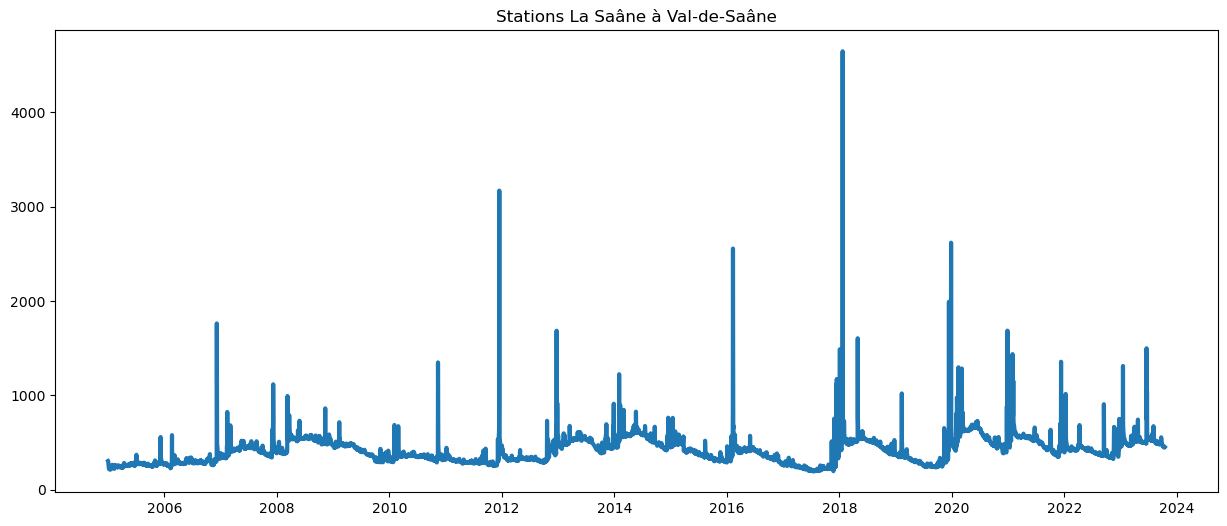

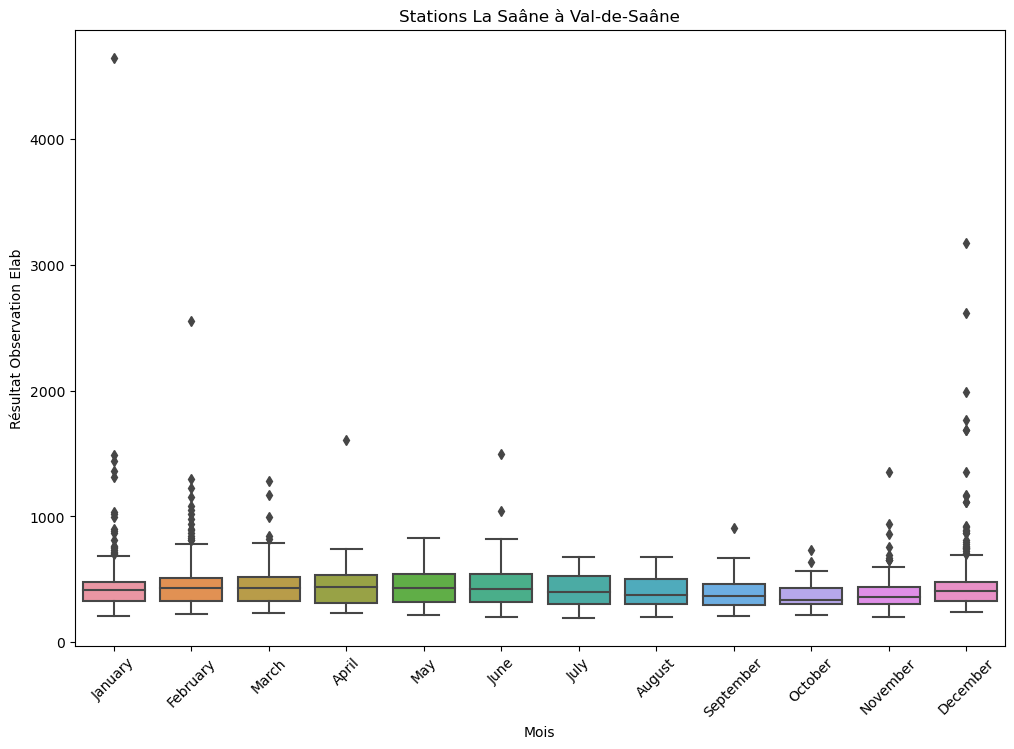

00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:58 - cmdstanpy - INFO - Chain [1] done processing


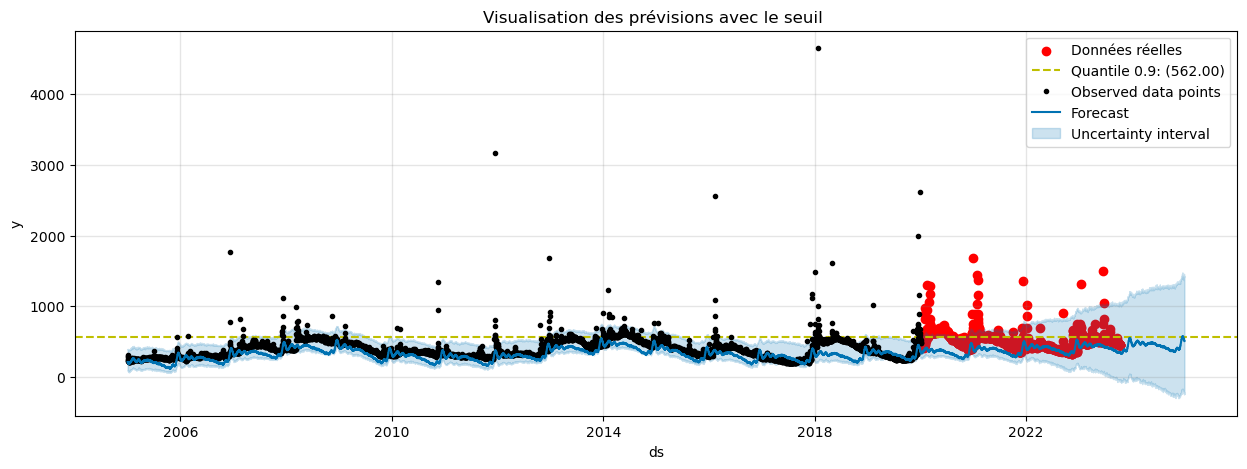

Nombre de fois où la hauteur est supérieur au quantile 0.9, qui est de 562 mètres : 8 dans les 1460 prochain jours


In [267]:
pred=construction_ts(data,0.9)

# Recuperation données

In [268]:
len(station)

710

In [271]:
result = []

In [272]:
n=0
for i in station:
    print(n)
    n=n+1
    dat=df[df['code_station']==i]
    train, test = mise_en_forme(dat)
    modele, prediction, pred_futur, pred_futur2 = model(train,test)
    jour=len(pred_futur2)
    
    quantiles = [0.95, 0.9, 0.85]
    quantile_counts = {}
    
    for q in quantiles:
        quantile_value = data["resultat_obs_elab"].quantile(q)
        count = (pred_futur2["yhat"] > quantile_value).sum()
        quantile_counts[f'quantile_{int(q * 100)}'] = count
    
    erreur_abs=erreur(test, prediction)
    
    result.append({
        'station': i, 
         "nb_jour":jour,
         "erreur": erreur_abs, 
         "NB_valeur":len(dat),
        **quantile_counts
    })


0


00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:40 - cmdstanpy - INFO - Chain [1] done processing


1


00:21:44 - cmdstanpy - INFO - Chain [1] start processing
00:21:44 - cmdstanpy - INFO - Chain [1] done processing


2


00:21:48 - cmdstanpy - INFO - Chain [1] start processing
00:21:48 - cmdstanpy - INFO - Chain [1] done processing


3


00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing
00:21:54 - cmdstanpy - INFO - Chain [1] start processing


4


00:21:54 - cmdstanpy - INFO - Chain [1] done processing


5


00:21:57 - cmdstanpy - INFO - Chain [1] start processing
00:21:57 - cmdstanpy - INFO - Chain [1] done processing


6


00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing


7


00:22:03 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing


8


00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing


9


00:22:10 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing
00:22:12 - cmdstanpy - INFO - Chain [1] start processing


10


00:22:12 - cmdstanpy - INFO - Chain [1] done processing


11


00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing


12


00:22:16 - cmdstanpy - INFO - Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing


13


00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing


14


00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing


15


00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:27 - cmdstanpy - INFO - Chain [1] done processing


16


00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:30 - cmdstanpy - INFO - Chain [1] done processing


17


00:22:33 - cmdstanpy - INFO - Chain [1] start processing
00:22:33 - cmdstanpy - INFO - Chain [1] done processing


18


00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:38 - cmdstanpy - INFO - Chain [1] done processing


19


00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing


20


00:22:48 - cmdstanpy - INFO - Chain [1] start processing
00:22:48 - cmdstanpy - INFO - Chain [1] done processing


21


00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing


22


00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:55 - cmdstanpy - INFO - Chain [1] done processing


23


00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


24


00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


25


00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


26


00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


27


00:23:08 - cmdstanpy - INFO - Chain [1] start processing
00:23:09 - cmdstanpy - INFO - Chain [1] done processing


28


00:23:11 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing


29


00:23:13 - cmdstanpy - INFO - Chain [1] start processing
00:23:13 - cmdstanpy - INFO - Chain [1] done processing


30


00:23:16 - cmdstanpy - INFO - Chain [1] start processing
00:23:16 - cmdstanpy - INFO - Chain [1] done processing


31


00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:18 - cmdstanpy - INFO - Chain [1] done processing


32


00:23:21 - cmdstanpy - INFO - Chain [1] start processing
00:23:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



33


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:23 - cmdstanpy - INFO - Chain [1] done processing


34


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:26 - cmdstanpy - INFO - Chain [1] done processing


35


00:23:27 - cmdstanpy - INFO - Chain [1] start processing
00:23:27 - cmdstanpy - INFO - Chain [1] done processing


36


00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing


37


00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:32 - cmdstanpy - INFO - Chain [1] done processing


38


00:23:33 - cmdstanpy - INFO - Chain [1] start processing
00:23:33 - cmdstanpy - INFO - Chain [1] done processing


39


00:23:34 - cmdstanpy - INFO - Chain [1] start processing
00:23:34 - cmdstanpy - INFO - Chain [1] done processing


40


00:23:35 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing


41


00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing


42


00:23:38 - cmdstanpy - INFO - Chain [1] done processing


43


00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing


44


00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing


45


00:23:41 - cmdstanpy - INFO - Chain [1] done processing


46


00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing


47


00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing


48


00:23:46 - cmdstanpy - INFO - Chain [1] start processing
00:23:46 - cmdstanpy - INFO - Chain [1] done processing


49


00:23:48 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing


50


00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:51 - cmdstanpy - INFO - Chain [1] done processing
00:23:53 - cmdstanpy - INFO - Chain [1] start processing


51


00:23:53 - cmdstanpy - INFO - Chain [1] done processing


52


00:23:54 - cmdstanpy - INFO - Chain [1] start processing
00:23:54 - cmdstanpy - INFO - Chain [1] done processing


53


00:23:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing
00:23:57 - cmdstanpy - INFO - Chain [1] start processing


54


00:23:57 - cmdstanpy - INFO - Chain [1] done processing


55


00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing


56


00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing


57


00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



58


00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing
00:24:10 - cmdstanpy - INFO - Chain [1] start processing


59


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
00:24:11 - cmdstanpy - INFO - Chain [1] start processing


60


00:24:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



61


00:24:13 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing


62


00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing
00:24:20 - cmdstanpy - INFO - Chain [1] start processing


63


00:24:20 - cmdstanpy - INFO - Chain [1] done processing


64


00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing


65


00:24:24 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing


66


00:24:29 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing


67


00:24:32 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing


68


00:24:35 - cmdstanpy - INFO - Chain [1] done processing


69


00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing


70


00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:40 - cmdstanpy - INFO - Chain [1] done processing


71


00:24:41 - cmdstanpy - INFO - Chain [1] start processing
00:24:43 - cmdstanpy - INFO - Chain [1] done processing


72


00:24:45 - cmdstanpy - INFO - Chain [1] start processing
00:24:46 - cmdstanpy - INFO - Chain [1] done processing


73


00:24:47 - cmdstanpy - INFO - Chain [1] start processing
00:24:48 - cmdstanpy - INFO - Chain [1] done processing


74


00:24:50 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing
00:24:52 - cmdstanpy - INFO - Chain [1] start processing


75


00:24:52 - cmdstanpy - INFO - Chain [1] done processing


76


00:24:55 - cmdstanpy - INFO - Chain [1] start processing
00:24:57 - cmdstanpy - INFO - Chain [1] done processing


77


00:24:59 - cmdstanpy - INFO - Chain [1] start processing
00:25:00 - cmdstanpy - INFO - Chain [1] done processing


78


00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing


79


00:25:05 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing


80


00:25:07 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing


81


00:25:09 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing
00:25:11 - cmdstanpy - INFO - Chain [1] start processing


82


00:25:11 - cmdstanpy - INFO - Chain [1] done processing


83


00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing


84


00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:19 - cmdstanpy - INFO - Chain [1] done processing


85


00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:24 - cmdstanpy - INFO - Chain [1] done processing


86


00:25:27 - cmdstanpy - INFO - Chain [1] start processing
00:25:28 - cmdstanpy - INFO - Chain [1] done processing


87


00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing


88


00:25:34 - cmdstanpy - INFO - Chain [1] done processing


89


00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:38 - cmdstanpy - INFO - Chain [1] done processing


90


00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing


91


00:25:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing


92


00:25:44 - cmdstanpy - INFO - Chain [1] start processing
00:25:44 - cmdstanpy - INFO - Chain [1] done processing


93


00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:47 - cmdstanpy - INFO - Chain [1] done processing


94


00:25:49 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing


95


00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing


96


00:25:59 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing


97


00:26:04 - cmdstanpy - INFO - Chain [1] start processing
00:26:05 - cmdstanpy - INFO - Chain [1] done processing


98


00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing


99


00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing


100


00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



101


00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing


102


00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing
00:26:24 - cmdstanpy - INFO - Chain [1] start processing


103


00:26:24 - cmdstanpy - INFO - Chain [1] done processing


104


00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing


105


00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing


106


00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:31 - cmdstanpy - INFO - Chain [1] done processing
00:26:33 - cmdstanpy - INFO - Chain [1] start processing


107


00:26:33 - cmdstanpy - INFO - Chain [1] done processing


108


00:26:36 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing


109


00:26:40 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing


110


00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:44 - cmdstanpy - INFO - Chain [1] done processing


111


00:26:46 - cmdstanpy - INFO - Chain [1] start processing
00:26:48 - cmdstanpy - INFO - Chain [1] done processing


112


00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:51 - cmdstanpy - INFO - Chain [1] done processing


113


00:26:52 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing


114


00:26:56 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing


115


00:27:01 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing


116


00:27:07 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing


117


00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing


118


00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing


119


00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing


120


00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing


121


00:27:26 - cmdstanpy - INFO - Chain [1] start processing
00:27:28 - cmdstanpy - INFO - Chain [1] done processing


122


00:27:31 - cmdstanpy - INFO - Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing


123


00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing


124


00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:41 - cmdstanpy - INFO - Chain [1] done processing


125


00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing


126


00:27:47 - cmdstanpy - INFO - Chain [1] start processing
00:27:48 - cmdstanpy - INFO - Chain [1] done processing


127


00:27:50 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing


128


00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing


129


00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:55 - cmdstanpy - INFO - Chain [1] done processing


130


00:27:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:59 - cmdstanpy - INFO - Chain [1] done processing


131


00:28:02 - cmdstanpy - INFO - Chain [1] start processing
00:28:02 - cmdstanpy - INFO - Chain [1] done processing


132


00:28:06 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing


133


00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:10 - cmdstanpy - INFO - Chain [1] done processing
00:28:11 - cmdstanpy - INFO - Chain [1] start processing


134


00:28:11 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing


135


00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing


136


00:28:13 - cmdstanpy - INFO - Chain [1] done processing


137


00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing


138


00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing


139


00:28:22 - cmdstanpy - INFO - Chain [1] start processing
00:28:22 - cmdstanpy - INFO - Chain [1] done processing


140


00:28:23 - cmdstanpy - INFO - Chain [1] start processing
00:28:24 - cmdstanpy - INFO - Chain [1] done processing


141


00:28:26 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing


142


00:28:31 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



143


00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:37 - cmdstanpy - INFO - Chain [1] done processing


144


00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



145


00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing


146


00:28:49 - cmdstanpy - INFO - Chain [1] start processing
00:28:50 - cmdstanpy - INFO - Chain [1] done processing


147


00:28:53 - cmdstanpy - INFO - Chain [1] start processing
00:28:54 - cmdstanpy - INFO - Chain [1] done processing


148


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:58 - cmdstanpy - INFO - Chain [1] done processing


149


00:29:01 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing


150


00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing


151


00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing


152


00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:19 - cmdstanpy - INFO - Chain [1] done processing


153


00:29:23 - cmdstanpy - INFO - Chain [1] start processing
00:29:24 - cmdstanpy - INFO - Chain [1] done processing


154


00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing


155


00:29:33 - cmdstanpy - INFO - Chain [1] start processing
00:29:34 - cmdstanpy - INFO - Chain [1] done processing


156


00:29:38 - cmdstanpy - INFO - Chain [1] start processing
00:29:41 - cmdstanpy - INFO - Chain [1] done processing


157


00:29:44 - cmdstanpy - INFO - Chain [1] start processing
00:29:46 - cmdstanpy - INFO - Chain [1] done processing


158


00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:49 - cmdstanpy - INFO - Chain [1] done processing


159


00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:53 - cmdstanpy - INFO - Chain [1] done processing


160


00:29:57 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing


161


00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing


162


00:30:07 - cmdstanpy - INFO - Chain [1] start processing
00:30:09 - cmdstanpy - INFO - Chain [1] done processing


163


00:30:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:15 - cmdstanpy - INFO - Chain [1] done processing


164


00:30:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:19 - cmdstanpy - INFO - Chain [1] done processing


165


00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:23 - cmdstanpy - INFO - Chain [1] done processing


166


00:30:25 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing


167


00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:32 - cmdstanpy - INFO - Chain [1] done processing


168


00:30:35 - cmdstanpy - INFO - Chain [1] start processing
00:30:36 - cmdstanpy - INFO - Chain [1] done processing


169


00:30:39 - cmdstanpy - INFO - Chain [1] start processing
00:30:39 - cmdstanpy - INFO - Chain [1] done processing


170


00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:43 - cmdstanpy - INFO - Chain [1] done processing


171


00:30:47 - cmdstanpy - INFO - Chain [1] start processing
00:30:48 - cmdstanpy - INFO - Chain [1] done processing


172


00:30:51 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing


173


00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing


174


00:30:59 - cmdstanpy - INFO - Chain [1] done processing


175


00:31:02 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing


176


00:31:07 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing
00:31:11 - cmdstanpy - INFO - Chain [1] start processing


177


00:31:13 - cmdstanpy - INFO - Chain [1] done processing


178


00:31:15 - cmdstanpy - INFO - Chain [1] start processing
00:31:16 - cmdstanpy - INFO - Chain [1] done processing


179


00:31:19 - cmdstanpy - INFO - Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing


180


00:31:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing


181


00:31:28 - cmdstanpy - INFO - Chain [1] start processing
00:31:28 - cmdstanpy - INFO - Chain [1] done processing


182


00:31:30 - cmdstanpy - INFO - Chain [1] start processing
00:31:31 - cmdstanpy - INFO - Chain [1] done processing


183


00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:34 - cmdstanpy - INFO - Chain [1] done processing
00:31:36 - cmdstanpy - INFO - Chain [1] start processing


184


00:31:37 - cmdstanpy - INFO - Chain [1] done processing


185


00:31:38 - cmdstanpy - INFO - Chain [1] start processing
00:31:38 - cmdstanpy - INFO - Chain [1] done processing


186


00:31:41 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing


187


00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing


188


00:31:48 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing


189


00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing


190


00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done processing


191


00:31:58 - cmdstanpy - INFO - Chain [1] start processing
00:31:58 - cmdstanpy - INFO - Chain [1] done processing
00:32:01 - cmdstanpy - INFO - Chain [1] start processing


192


00:32:01 - cmdstanpy - INFO - Chain [1] done processing


193


00:32:03 - cmdstanpy - INFO - Chain [1] start processing
00:32:04 - cmdstanpy - INFO - Chain [1] done processing


194


00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing


195


00:32:11 - cmdstanpy - INFO - Chain [1] start processing
00:32:11 - cmdstanpy - INFO - Chain [1] done processing


196


00:32:15 - cmdstanpy - INFO - Chain [1] start processing
00:32:16 - cmdstanpy - INFO - Chain [1] done processing


197


00:32:19 - cmdstanpy - INFO - Chain [1] start processing
00:32:20 - cmdstanpy - INFO - Chain [1] done processing


198


00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:24 - cmdstanpy - INFO - Chain [1] done processing


199


00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:28 - cmdstanpy - INFO - Chain [1] done processing


200


00:32:31 - cmdstanpy - INFO - Chain [1] start processing
00:32:33 - cmdstanpy - INFO - Chain [1] done processing


201


00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing


202


00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing


203


00:32:41 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing


204


00:32:45 - cmdstanpy - INFO - Chain [1] start processing
00:32:46 - cmdstanpy - INFO - Chain [1] done processing


205


00:32:47 - cmdstanpy - INFO - Chain [1] start processing
00:32:47 - cmdstanpy - INFO - Chain [1] done processing


206


00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:32:52 - cmdstanpy - INFO - Chain [1] done processing


207


00:32:54 - cmdstanpy - INFO - Chain [1] start processing
00:32:54 - cmdstanpy - INFO - Chain [1] done processing


208


00:32:57 - cmdstanpy - INFO - Chain [1] start processing
00:32:57 - cmdstanpy - INFO - Chain [1] done processing


209


00:33:01 - cmdstanpy - INFO - Chain [1] start processing
00:33:02 - cmdstanpy - INFO - Chain [1] done processing
00:33:05 - cmdstanpy - INFO - Chain [1] start processing


210


00:33:05 - cmdstanpy - INFO - Chain [1] done processing


211


00:33:08 - cmdstanpy - INFO - Chain [1] start processing
00:33:10 - cmdstanpy - INFO - Chain [1] done processing


212


00:33:13 - cmdstanpy - INFO - Chain [1] start processing
00:33:13 - cmdstanpy - INFO - Chain [1] done processing


213


00:33:16 - cmdstanpy - INFO - Chain [1] start processing
00:33:16 - cmdstanpy - INFO - Chain [1] done processing
00:33:18 - cmdstanpy - INFO - Chain [1] start processing


214


00:33:25 - cmdstanpy - INFO - Chain [1] done processing


215


00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing


216


00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing


217


00:33:34 - cmdstanpy - INFO - Chain [1] start processing
00:33:36 - cmdstanpy - INFO - Chain [1] done processing


218


00:33:39 - cmdstanpy - INFO - Chain [1] start processing
00:33:41 - cmdstanpy - INFO - Chain [1] done processing


219


00:33:44 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing


220


00:33:47 - cmdstanpy - INFO - Chain [1] start processing
00:33:47 - cmdstanpy - INFO - Chain [1] done processing


221


00:33:49 - cmdstanpy - INFO - Chain [1] start processing
00:33:50 - cmdstanpy - INFO - Chain [1] done processing


222


00:33:53 - cmdstanpy - INFO - Chain [1] start processing
00:33:55 - cmdstanpy - INFO - Chain [1] done processing


223


00:33:58 - cmdstanpy - INFO - Chain [1] start processing
00:33:58 - cmdstanpy - INFO - Chain [1] done processing


224


00:34:00 - cmdstanpy - INFO - Chain [1] start processing
00:34:00 - cmdstanpy - INFO - Chain [1] done processing
00:34:03 - cmdstanpy - INFO - Chain [1] start processing


225


00:34:03 - cmdstanpy - INFO - Chain [1] done processing


226


00:34:06 - cmdstanpy - INFO - Chain [1] start processing
00:34:08 - cmdstanpy - INFO - Chain [1] done processing


227


00:34:11 - cmdstanpy - INFO - Chain [1] start processing
00:34:13 - cmdstanpy - INFO - Chain [1] done processing


228


00:34:15 - cmdstanpy - INFO - Chain [1] start processing
00:34:16 - cmdstanpy - INFO - Chain [1] done processing


229


00:34:19 - cmdstanpy - INFO - Chain [1] start processing
00:34:21 - cmdstanpy - INFO - Chain [1] done processing


230


00:34:23 - cmdstanpy - INFO - Chain [1] start processing
00:34:24 - cmdstanpy - INFO - Chain [1] done processing
00:34:25 - cmdstanpy - INFO - Chain [1] start processing


231


00:34:26 - cmdstanpy - INFO - Chain [1] done processing
00:34:26 - cmdstanpy - INFO - Chain [1] start processing


232


00:34:27 - cmdstanpy - INFO - Chain [1] done processing


233


00:34:28 - cmdstanpy - INFO - Chain [1] start processing
00:34:30 - cmdstanpy - INFO - Chain [1] done processing


234


00:34:33 - cmdstanpy - INFO - Chain [1] start processing
00:34:33 - cmdstanpy - INFO - Chain [1] done processing


235


00:34:35 - cmdstanpy - INFO - Chain [1] start processing
00:34:37 - cmdstanpy - INFO - Chain [1] done processing


236


00:34:40 - cmdstanpy - INFO - Chain [1] start processing
00:34:41 - cmdstanpy - INFO - Chain [1] done processing


237


00:34:44 - cmdstanpy - INFO - Chain [1] start processing
00:34:45 - cmdstanpy - INFO - Chain [1] done processing


238


00:34:47 - cmdstanpy - INFO - Chain [1] start processing
00:34:48 - cmdstanpy - INFO - Chain [1] done processing


239


00:34:50 - cmdstanpy - INFO - Chain [1] start processing
00:34:50 - cmdstanpy - INFO - Chain [1] done processing


240


00:34:53 - cmdstanpy - INFO - Chain [1] start processing
00:34:54 - cmdstanpy - INFO - Chain [1] done processing


241


00:34:56 - cmdstanpy - INFO - Chain [1] start processing
00:34:57 - cmdstanpy - INFO - Chain [1] done processing


242


00:35:00 - cmdstanpy - INFO - Chain [1] start processing
00:35:01 - cmdstanpy - INFO - Chain [1] done processing


243


00:35:04 - cmdstanpy - INFO - Chain [1] start processing
00:35:06 - cmdstanpy - INFO - Chain [1] done processing


244


00:35:09 - cmdstanpy - INFO - Chain [1] start processing
00:35:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



245


00:35:12 - cmdstanpy - INFO - Chain [1] start processing
00:35:12 - cmdstanpy - INFO - Chain [1] done processing


246


00:35:16 - cmdstanpy - INFO - Chain [1] start processing
00:35:16 - cmdstanpy - INFO - Chain [1] done processing


247


00:35:19 - cmdstanpy - INFO - Chain [1] start processing
00:35:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



248


00:35:21 - cmdstanpy - INFO - Chain [1] start processing
00:35:21 - cmdstanpy - INFO - Chain [1] done processing


249


00:35:24 - cmdstanpy - INFO - Chain [1] start processing
00:35:25 - cmdstanpy - INFO - Chain [1] done processing


250


00:35:28 - cmdstanpy - INFO - Chain [1] start processing
00:35:29 - cmdstanpy - INFO - Chain [1] done processing


251


00:35:32 - cmdstanpy - INFO - Chain [1] start processing
00:35:32 - cmdstanpy - INFO - Chain [1] done processing


252


00:35:33 - cmdstanpy - INFO - Chain [1] start processing
00:35:34 - cmdstanpy - INFO - Chain [1] done processing


253


00:35:37 - cmdstanpy - INFO - Chain [1] start processing
00:35:39 - cmdstanpy - INFO - Chain [1] done processing


254


00:35:41 - cmdstanpy - INFO - Chain [1] start processing
00:35:41 - cmdstanpy - INFO - Chain [1] done processing


255


00:35:44 - cmdstanpy - INFO - Chain [1] start processing
00:35:44 - cmdstanpy - INFO - Chain [1] done processing


256


00:35:46 - cmdstanpy - INFO - Chain [1] start processing
00:35:48 - cmdstanpy - INFO - Chain [1] done processing


257


00:35:50 - cmdstanpy - INFO - Chain [1] start processing
00:35:51 - cmdstanpy - INFO - Chain [1] done processing


258


00:35:53 - cmdstanpy - INFO - Chain [1] start processing
00:35:54 - cmdstanpy - INFO - Chain [1] done processing


259


00:35:57 - cmdstanpy - INFO - Chain [1] start processing
00:35:57 - cmdstanpy - INFO - Chain [1] done processing


260


00:35:59 - cmdstanpy - INFO - Chain [1] start processing
00:36:00 - cmdstanpy - INFO - Chain [1] done processing


261


00:36:02 - cmdstanpy - INFO - Chain [1] start processing
00:36:03 - cmdstanpy - INFO - Chain [1] done processing


262


00:36:06 - cmdstanpy - INFO - Chain [1] start processing
00:36:08 - cmdstanpy - INFO - Chain [1] done processing


263


00:36:11 - cmdstanpy - INFO - Chain [1] start processing
00:36:12 - cmdstanpy - INFO - Chain [1] done processing


264


00:36:15 - cmdstanpy - INFO - Chain [1] start processing
00:36:16 - cmdstanpy - INFO - Chain [1] done processing


265


00:36:18 - cmdstanpy - INFO - Chain [1] start processing
00:36:19 - cmdstanpy - INFO - Chain [1] done processing


266


00:36:21 - cmdstanpy - INFO - Chain [1] start processing
00:36:22 - cmdstanpy - INFO - Chain [1] done processing


267


00:36:25 - cmdstanpy - INFO - Chain [1] start processing
00:36:26 - cmdstanpy - INFO - Chain [1] done processing


268


00:36:29 - cmdstanpy - INFO - Chain [1] start processing
00:36:30 - cmdstanpy - INFO - Chain [1] done processing


269


00:36:33 - cmdstanpy - INFO - Chain [1] start processing
00:36:34 - cmdstanpy - INFO - Chain [1] done processing


270


00:36:36 - cmdstanpy - INFO - Chain [1] start processing
00:36:37 - cmdstanpy - INFO - Chain [1] done processing


271


00:36:39 - cmdstanpy - INFO - Chain [1] start processing
00:36:40 - cmdstanpy - INFO - Chain [1] done processing


272


00:36:43 - cmdstanpy - INFO - Chain [1] start processing
00:36:44 - cmdstanpy - INFO - Chain [1] done processing


273


00:36:47 - cmdstanpy - INFO - Chain [1] start processing
00:36:49 - cmdstanpy - INFO - Chain [1] done processing


274


00:36:52 - cmdstanpy - INFO - Chain [1] start processing
00:36:52 - cmdstanpy - INFO - Chain [1] done processing


275


00:36:54 - cmdstanpy - INFO - Chain [1] start processing
00:36:55 - cmdstanpy - INFO - Chain [1] done processing


276


00:36:57 - cmdstanpy - INFO - Chain [1] start processing
00:36:57 - cmdstanpy - INFO - Chain [1] done processing


277


00:37:00 - cmdstanpy - INFO - Chain [1] start processing
00:37:02 - cmdstanpy - INFO - Chain [1] done processing


278


00:37:05 - cmdstanpy - INFO - Chain [1] start processing
00:37:05 - cmdstanpy - INFO - Chain [1] done processing


279


00:37:07 - cmdstanpy - INFO - Chain [1] start processing
00:37:07 - cmdstanpy - INFO - Chain [1] done processing


280


00:37:09 - cmdstanpy - INFO - Chain [1] start processing
00:37:10 - cmdstanpy - INFO - Chain [1] done processing


281


00:37:13 - cmdstanpy - INFO - Chain [1] start processing
00:37:13 - cmdstanpy - INFO - Chain [1] done processing


282


00:37:15 - cmdstanpy - INFO - Chain [1] start processing
00:37:15 - cmdstanpy - INFO - Chain [1] done processing


283


00:37:16 - cmdstanpy - INFO - Chain [1] start processing
00:37:17 - cmdstanpy - INFO - Chain [1] done processing


284


00:37:19 - cmdstanpy - INFO - Chain [1] start processing
00:37:19 - cmdstanpy - INFO - Chain [1] done processing


285


00:37:21 - cmdstanpy - INFO - Chain [1] start processing
00:37:21 - cmdstanpy - INFO - Chain [1] done processing


286


00:37:24 - cmdstanpy - INFO - Chain [1] start processing
00:37:26 - cmdstanpy - INFO - Chain [1] done processing


287


00:37:29 - cmdstanpy - INFO - Chain [1] start processing
00:37:30 - cmdstanpy - INFO - Chain [1] done processing


288


00:37:33 - cmdstanpy - INFO - Chain [1] start processing
00:37:35 - cmdstanpy - INFO - Chain [1] done processing


289


00:37:39 - cmdstanpy - INFO - Chain [1] start processing
00:37:41 - cmdstanpy - INFO - Chain [1] done processing


290


00:37:44 - cmdstanpy - INFO - Chain [1] start processing
00:37:45 - cmdstanpy - INFO - Chain [1] done processing


291


00:37:49 - cmdstanpy - INFO - Chain [1] start processing
00:37:51 - cmdstanpy - INFO - Chain [1] done processing
00:37:54 - cmdstanpy - INFO - Chain [1] start processing


292


00:37:54 - cmdstanpy - INFO - Chain [1] done processing


293


00:37:58 - cmdstanpy - INFO - Chain [1] start processing
00:38:00 - cmdstanpy - INFO - Chain [1] done processing


294


00:38:03 - cmdstanpy - INFO - Chain [1] start processing
00:38:05 - cmdstanpy - INFO - Chain [1] done processing


295


00:38:08 - cmdstanpy - INFO - Chain [1] start processing
00:38:09 - cmdstanpy - INFO - Chain [1] done processing


296


00:38:12 - cmdstanpy - INFO - Chain [1] start processing
00:38:14 - cmdstanpy - INFO - Chain [1] done processing


297


00:38:17 - cmdstanpy - INFO - Chain [1] start processing
00:38:19 - cmdstanpy - INFO - Chain [1] done processing


298


00:38:23 - cmdstanpy - INFO - Chain [1] start processing
00:38:24 - cmdstanpy - INFO - Chain [1] done processing


299


00:38:27 - cmdstanpy - INFO - Chain [1] start processing
00:38:28 - cmdstanpy - INFO - Chain [1] done processing


300


00:38:31 - cmdstanpy - INFO - Chain [1] start processing
00:38:32 - cmdstanpy - INFO - Chain [1] done processing


301


00:38:36 - cmdstanpy - INFO - Chain [1] start processing
00:38:37 - cmdstanpy - INFO - Chain [1] done processing


302


00:38:41 - cmdstanpy - INFO - Chain [1] start processing
00:38:41 - cmdstanpy - INFO - Chain [1] done processing
00:38:43 - cmdstanpy - INFO - Chain [1] start processing


303


00:38:43 - cmdstanpy - INFO - Chain [1] done processing


304


00:38:46 - cmdstanpy - INFO - Chain [1] start processing
00:38:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



305


00:38:50 - cmdstanpy - INFO - Chain [1] start processing
00:38:50 - cmdstanpy - INFO - Chain [1] done processing


306


00:38:53 - cmdstanpy - INFO - Chain [1] start processing
00:38:54 - cmdstanpy - INFO - Chain [1] done processing


307


00:38:58 - cmdstanpy - INFO - Chain [1] start processing
00:38:59 - cmdstanpy - INFO - Chain [1] done processing
00:39:02 - cmdstanpy - INFO - Chain [1] start processing


308


00:39:02 - cmdstanpy - INFO - Chain [1] done processing


309


00:39:05 - cmdstanpy - INFO - Chain [1] start processing
00:39:06 - cmdstanpy - INFO - Chain [1] done processing
00:39:09 - cmdstanpy - INFO - Chain [1] start processing


310


00:39:09 - cmdstanpy - INFO - Chain [1] done processing


311


00:39:11 - cmdstanpy - INFO - Chain [1] start processing
00:39:12 - cmdstanpy - INFO - Chain [1] done processing


312


00:39:15 - cmdstanpy - INFO - Chain [1] start processing
00:39:17 - cmdstanpy - INFO - Chain [1] done processing


313


00:39:20 - cmdstanpy - INFO - Chain [1] start processing
00:39:20 - cmdstanpy - INFO - Chain [1] done processing


314


00:39:22 - cmdstanpy - INFO - Chain [1] start processing
00:39:23 - cmdstanpy - INFO - Chain [1] done processing


315


00:39:26 - cmdstanpy - INFO - Chain [1] start processing
00:39:28 - cmdstanpy - INFO - Chain [1] done processing


316


00:39:31 - cmdstanpy - INFO - Chain [1] start processing
00:39:33 - cmdstanpy - INFO - Chain [1] done processing


317


00:39:36 - cmdstanpy - INFO - Chain [1] start processing
00:39:37 - cmdstanpy - INFO - Chain [1] done processing


318


00:39:40 - cmdstanpy - INFO - Chain [1] start processing
00:39:41 - cmdstanpy - INFO - Chain [1] done processing
00:39:42 - cmdstanpy - INFO - Chain [1] start processing


319


00:39:43 - cmdstanpy - INFO - Chain [1] done processing


320


00:39:43 - cmdstanpy - INFO - Chain [1] start processing
00:39:43 - cmdstanpy - INFO - Chain [1] done processing


321


00:39:47 - cmdstanpy - INFO - Chain [1] start processing
00:39:48 - cmdstanpy - INFO - Chain [1] done processing


322


00:39:50 - cmdstanpy - INFO - Chain [1] start processing
00:39:50 - cmdstanpy - INFO - Chain [1] done processing


323


00:39:52 - cmdstanpy - INFO - Chain [1] start processing
00:39:53 - cmdstanpy - INFO - Chain [1] done processing


324


00:39:57 - cmdstanpy - INFO - Chain [1] start processing
00:39:59 - cmdstanpy - INFO - Chain [1] done processing


325


00:40:02 - cmdstanpy - INFO - Chain [1] start processing
00:40:04 - cmdstanpy - INFO - Chain [1] done processing


326


00:40:07 - cmdstanpy - INFO - Chain [1] start processing
00:40:08 - cmdstanpy - INFO - Chain [1] done processing


327


00:40:11 - cmdstanpy - INFO - Chain [1] start processing
00:40:13 - cmdstanpy - INFO - Chain [1] done processing


328


00:40:16 - cmdstanpy - INFO - Chain [1] start processing
00:40:18 - cmdstanpy - INFO - Chain [1] done processing


329


00:40:21 - cmdstanpy - INFO - Chain [1] start processing
00:40:23 - cmdstanpy - INFO - Chain [1] done processing


330


00:40:26 - cmdstanpy - INFO - Chain [1] start processing
00:40:28 - cmdstanpy - INFO - Chain [1] done processing


331


00:40:31 - cmdstanpy - INFO - Chain [1] start processing
00:40:31 - cmdstanpy - INFO - Chain [1] done processing


332


00:40:32 - cmdstanpy - INFO - Chain [1] start processing
00:40:33 - cmdstanpy - INFO - Chain [1] done processing


333


00:40:35 - cmdstanpy - INFO - Chain [1] start processing
00:40:35 - cmdstanpy - INFO - Chain [1] done processing


334


00:40:37 - cmdstanpy - INFO - Chain [1] start processing
00:40:38 - cmdstanpy - INFO - Chain [1] done processing


335


00:40:40 - cmdstanpy - INFO - Chain [1] start processing
00:40:40 - cmdstanpy - INFO - Chain [1] done processing


336


00:40:42 - cmdstanpy - INFO - Chain [1] start processing
00:40:42 - cmdstanpy - INFO - Chain [1] done processing


337


00:40:43 - cmdstanpy - INFO - Chain [1] start processing
00:40:44 - cmdstanpy - INFO - Chain [1] done processing


338


00:40:45 - cmdstanpy - INFO - Chain [1] start processing
00:40:47 - cmdstanpy - INFO - Chain [1] done processing


339


00:40:50 - cmdstanpy - INFO - Chain [1] start processing
00:40:50 - cmdstanpy - INFO - Chain [1] done processing
00:40:52 - cmdstanpy - INFO - Chain [1] start processing


340


00:40:52 - cmdstanpy - INFO - Chain [1] done processing


341


00:40:54 - cmdstanpy - INFO - Chain [1] start processing
00:40:54 - cmdstanpy - INFO - Chain [1] done processing


342


00:40:56 - cmdstanpy - INFO - Chain [1] start processing
00:40:56 - cmdstanpy - INFO - Chain [1] done processing


343


00:40:57 - cmdstanpy - INFO - Chain [1] start processing
00:40:58 - cmdstanpy - INFO - Chain [1] done processing


344


00:41:00 - cmdstanpy - INFO - Chain [1] start processing
00:41:01 - cmdstanpy - INFO - Chain [1] done processing


345


00:41:05 - cmdstanpy - INFO - Chain [1] start processing
00:41:06 - cmdstanpy - INFO - Chain [1] done processing


346


00:41:09 - cmdstanpy - INFO - Chain [1] start processing
00:41:10 - cmdstanpy - INFO - Chain [1] done processing


347


00:41:12 - cmdstanpy - INFO - Chain [1] start processing
00:41:12 - cmdstanpy - INFO - Chain [1] done processing


348


00:41:14 - cmdstanpy - INFO - Chain [1] start processing
00:41:16 - cmdstanpy - INFO - Chain [1] done processing


349


00:41:19 - cmdstanpy - INFO - Chain [1] start processing
00:41:20 - cmdstanpy - INFO - Chain [1] done processing


350


00:41:24 - cmdstanpy - INFO - Chain [1] start processing
00:41:26 - cmdstanpy - INFO - Chain [1] done processing


351


00:41:29 - cmdstanpy - INFO - Chain [1] start processing
00:41:30 - cmdstanpy - INFO - Chain [1] done processing


352


00:41:34 - cmdstanpy - INFO - Chain [1] start processing
00:41:35 - cmdstanpy - INFO - Chain [1] done processing


353


00:41:38 - cmdstanpy - INFO - Chain [1] start processing
00:41:40 - cmdstanpy - INFO - Chain [1] done processing


354


00:41:43 - cmdstanpy - INFO - Chain [1] start processing
00:41:44 - cmdstanpy - INFO - Chain [1] done processing
00:41:47 - cmdstanpy - INFO - Chain [1] start processing


355


00:41:47 - cmdstanpy - INFO - Chain [1] done processing


356


00:41:48 - cmdstanpy - INFO - Chain [1] start processing
00:41:49 - cmdstanpy - INFO - Chain [1] done processing


357


00:41:53 - cmdstanpy - INFO - Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing


358


00:41:57 - cmdstanpy - INFO - Chain [1] start processing
00:41:59 - cmdstanpy - INFO - Chain [1] done processing


359


00:42:02 - cmdstanpy - INFO - Chain [1] start processing
00:42:03 - cmdstanpy - INFO - Chain [1] done processing
00:42:05 - cmdstanpy - INFO - Chain [1] start processing


360


00:42:05 - cmdstanpy - INFO - Chain [1] done processing


361


00:42:07 - cmdstanpy - INFO - Chain [1] start processing
00:42:09 - cmdstanpy - INFO - Chain [1] done processing


362


00:42:12 - cmdstanpy - INFO - Chain [1] start processing
00:42:14 - cmdstanpy - INFO - Chain [1] done processing


363


00:42:17 - cmdstanpy - INFO - Chain [1] start processing
00:42:18 - cmdstanpy - INFO - Chain [1] done processing


364


00:42:21 - cmdstanpy - INFO - Chain [1] start processing
00:42:22 - cmdstanpy - INFO - Chain [1] done processing


365


00:42:24 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing


366


00:42:26 - cmdstanpy - INFO - Chain [1] start processing
00:42:30 - cmdstanpy - INFO - Chain [1] done processing


367


00:42:33 - cmdstanpy - INFO - Chain [1] start processing
00:42:33 - cmdstanpy - INFO - Chain [1] done processing


368


00:42:35 - cmdstanpy - INFO - Chain [1] start processing
00:42:38 - cmdstanpy - INFO - Chain [1] done processing


369


00:42:41 - cmdstanpy - INFO - Chain [1] start processing
00:42:43 - cmdstanpy - INFO - Chain [1] done processing


370


00:42:46 - cmdstanpy - INFO - Chain [1] start processing
00:42:46 - cmdstanpy - INFO - Chain [1] done processing


371


00:42:48 - cmdstanpy - INFO - Chain [1] start processing
00:42:49 - cmdstanpy - INFO - Chain [1] done processing


372


00:42:53 - cmdstanpy - INFO - Chain [1] start processing
00:42:55 - cmdstanpy - INFO - Chain [1] done processing


373


00:42:58 - cmdstanpy - INFO - Chain [1] start processing
00:42:59 - cmdstanpy - INFO - Chain [1] done processing


374


00:43:02 - cmdstanpy - INFO - Chain [1] start processing
00:43:03 - cmdstanpy - INFO - Chain [1] done processing


375


00:43:06 - cmdstanpy - INFO - Chain [1] start processing
00:43:06 - cmdstanpy - INFO - Chain [1] done processing


376


00:43:08 - cmdstanpy - INFO - Chain [1] start processing
00:43:09 - cmdstanpy - INFO - Chain [1] done processing


377


00:43:12 - cmdstanpy - INFO - Chain [1] start processing
00:43:13 - cmdstanpy - INFO - Chain [1] done processing


378


00:43:16 - cmdstanpy - INFO - Chain [1] start processing
00:43:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



379


00:43:21 - cmdstanpy - INFO - Chain [1] start processing
00:43:21 - cmdstanpy - INFO - Chain [1] done processing


380


00:43:23 - cmdstanpy - INFO - Chain [1] start processing
00:43:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



381


00:43:26 - cmdstanpy - INFO - Chain [1] start processing
00:43:29 - cmdstanpy - INFO - Chain [1] done processing


382


00:43:32 - cmdstanpy - INFO - Chain [1] start processing
00:43:32 - cmdstanpy - INFO - Chain [1] done processing


383


00:43:34 - cmdstanpy - INFO - Chain [1] start processing
00:43:34 - cmdstanpy - INFO - Chain [1] done processing


384


00:43:37 - cmdstanpy - INFO - Chain [1] start processing
00:43:39 - cmdstanpy - INFO - Chain [1] done processing


385


00:43:42 - cmdstanpy - INFO - Chain [1] start processing
00:43:44 - cmdstanpy - INFO - Chain [1] done processing


386


00:43:47 - cmdstanpy - INFO - Chain [1] start processing
00:43:47 - cmdstanpy - INFO - Chain [1] done processing


387


00:43:48 - cmdstanpy - INFO - Chain [1] start processing
00:43:48 - cmdstanpy - INFO - Chain [1] done processing


388


00:43:51 - cmdstanpy - INFO - Chain [1] start processing
00:43:51 - cmdstanpy - INFO - Chain [1] done processing


389


00:43:55 - cmdstanpy - INFO - Chain [1] start processing
00:43:57 - cmdstanpy - INFO - Chain [1] done processing


390


00:44:01 - cmdstanpy - INFO - Chain [1] start processing
00:44:03 - cmdstanpy - INFO - Chain [1] done processing


391


00:44:06 - cmdstanpy - INFO - Chain [1] start processing
00:44:09 - cmdstanpy - INFO - Chain [1] done processing


392


00:44:12 - cmdstanpy - INFO - Chain [1] start processing
00:44:13 - cmdstanpy - INFO - Chain [1] done processing


393


00:44:16 - cmdstanpy - INFO - Chain [1] start processing
00:44:18 - cmdstanpy - INFO - Chain [1] done processing


394


00:44:21 - cmdstanpy - INFO - Chain [1] start processing
00:44:24 - cmdstanpy - INFO - Chain [1] done processing


395


00:44:26 - cmdstanpy - INFO - Chain [1] start processing
00:44:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



396


00:44:28 - cmdstanpy - INFO - Chain [1] start processing
00:44:28 - cmdstanpy - INFO - Chain [1] done processing


397


00:44:31 - cmdstanpy - INFO - Chain [1] start processing
00:44:33 - cmdstanpy - INFO - Chain [1] done processing


398


00:44:35 - cmdstanpy - INFO - Chain [1] start processing
00:44:38 - cmdstanpy - INFO - Chain [1] done processing


399


00:44:41 - cmdstanpy - INFO - Chain [1] start processing
00:44:42 - cmdstanpy - INFO - Chain [1] done processing


400


00:44:45 - cmdstanpy - INFO - Chain [1] start processing
00:44:46 - cmdstanpy - INFO - Chain [1] done processing


401


00:44:49 - cmdstanpy - INFO - Chain [1] start processing
00:44:50 - cmdstanpy - INFO - Chain [1] done processing


402


00:44:53 - cmdstanpy - INFO - Chain [1] start processing
00:44:55 - cmdstanpy - INFO - Chain [1] done processing


403


00:44:57 - cmdstanpy - INFO - Chain [1] start processing
00:44:58 - cmdstanpy - INFO - Chain [1] done processing


404


00:44:59 - cmdstanpy - INFO - Chain [1] start processing
00:45:02 - cmdstanpy - INFO - Chain [1] done processing


405


00:45:06 - cmdstanpy - INFO - Chain [1] start processing
00:45:08 - cmdstanpy - INFO - Chain [1] done processing


406


00:45:12 - cmdstanpy - INFO - Chain [1] start processing
00:45:14 - cmdstanpy - INFO - Chain [1] done processing


407


00:45:17 - cmdstanpy - INFO - Chain [1] start processing
00:45:18 - cmdstanpy - INFO - Chain [1] done processing


408


00:45:20 - cmdstanpy - INFO - Chain [1] start processing
00:45:22 - cmdstanpy - INFO - Chain [1] done processing


409


00:45:25 - cmdstanpy - INFO - Chain [1] start processing
00:45:27 - cmdstanpy - INFO - Chain [1] done processing


410


00:45:30 - cmdstanpy - INFO - Chain [1] start processing
00:45:32 - cmdstanpy - INFO - Chain [1] done processing
00:45:34 - cmdstanpy - INFO - Chain [1] start processing


411


00:45:34 - cmdstanpy - INFO - Chain [1] done processing


412


00:45:36 - cmdstanpy - INFO - Chain [1] start processing
00:45:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



413


00:45:41 - cmdstanpy - INFO - Chain [1] start processing
00:45:42 - cmdstanpy - INFO - Chain [1] done processing


414


00:45:46 - cmdstanpy - INFO - Chain [1] start processing
00:45:47 - cmdstanpy - INFO - Chain [1] done processing


415


00:45:50 - cmdstanpy - INFO - Chain [1] start processing
00:45:51 - cmdstanpy - INFO - Chain [1] done processing


416


00:45:53 - cmdstanpy - INFO - Chain [1] start processing
00:45:55 - cmdstanpy - INFO - Chain [1] done processing


417


00:45:59 - cmdstanpy - INFO - Chain [1] start processing
00:46:00 - cmdstanpy - INFO - Chain [1] done processing


418


00:46:03 - cmdstanpy - INFO - Chain [1] start processing
00:46:03 - cmdstanpy - INFO - Chain [1] done processing


419


00:46:05 - cmdstanpy - INFO - Chain [1] start processing
00:46:06 - cmdstanpy - INFO - Chain [1] done processing


420


00:46:10 - cmdstanpy - INFO - Chain [1] start processing
00:46:10 - cmdstanpy - INFO - Chain [1] done processing


421


00:46:13 - cmdstanpy - INFO - Chain [1] start processing
00:46:16 - cmdstanpy - INFO - Chain [1] done processing


422


00:46:19 - cmdstanpy - INFO - Chain [1] start processing
00:46:26 - cmdstanpy - INFO - Chain [1] done processing


423


00:46:29 - cmdstanpy - INFO - Chain [1] start processing
00:46:29 - cmdstanpy - INFO - Chain [1] done processing


424


00:46:32 - cmdstanpy - INFO - Chain [1] start processing
00:46:36 - cmdstanpy - INFO - Chain [1] done processing


425


00:46:39 - cmdstanpy - INFO - Chain [1] start processing
00:46:39 - cmdstanpy - INFO - Chain [1] done processing


426


00:46:40 - cmdstanpy - INFO - Chain [1] start processing
00:46:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



427


00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:46 - cmdstanpy - INFO - Chain [1] done processing


428


00:46:50 - cmdstanpy - INFO - Chain [1] start processing
00:46:52 - cmdstanpy - INFO - Chain [1] done processing
00:46:55 - cmdstanpy - INFO - Chain [1] start processing


429


00:46:55 - cmdstanpy - INFO - Chain [1] done processing


430


00:46:58 - cmdstanpy - INFO - Chain [1] start processing
00:46:59 - cmdstanpy - INFO - Chain [1] done processing


431


00:47:02 - cmdstanpy - INFO - Chain [1] start processing
00:47:08 - cmdstanpy - INFO - Chain [1] done processing


432


00:47:11 - cmdstanpy - INFO - Chain [1] start processing
00:47:16 - cmdstanpy - INFO - Chain [1] done processing


433


00:47:20 - cmdstanpy - INFO - Chain [1] start processing
00:47:22 - cmdstanpy - INFO - Chain [1] done processing


434


00:47:25 - cmdstanpy - INFO - Chain [1] start processing
00:47:25 - cmdstanpy - INFO - Chain [1] done processing


435


00:47:27 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1] done processing
00:47:33 - cmdstanpy - INFO - Chain [1] start processing


436


00:47:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



437


00:47:35 - cmdstanpy - INFO - Chain [1] start processing
00:47:39 - cmdstanpy - INFO - Chain [1] done processing


438


00:47:42 - cmdstanpy - INFO - Chain [1] start processing
00:47:44 - cmdstanpy - INFO - Chain [1] done processing


439


00:47:46 - cmdstanpy - INFO - Chain [1] start processing
00:47:48 - cmdstanpy - INFO - Chain [1] done processing


440


00:47:51 - cmdstanpy - INFO - Chain [1] start processing
00:47:54 - cmdstanpy - INFO - Chain [1] done processing
00:47:56 - cmdstanpy - INFO - Chain [1] start processing


441


00:47:57 - cmdstanpy - INFO - Chain [1] done processing


442


00:48:00 - cmdstanpy - INFO - Chain [1] start processing
00:48:02 - cmdstanpy - INFO - Chain [1] done processing


443


00:48:05 - cmdstanpy - INFO - Chain [1] start processing
00:48:05 - cmdstanpy - INFO - Chain [1] done processing


444


00:48:07 - cmdstanpy - INFO - Chain [1] start processing
00:48:08 - cmdstanpy - INFO - Chain [1] done processing
00:48:09 - cmdstanpy - INFO - Chain [1] start processing


445


00:48:09 - cmdstanpy - INFO - Chain [1] done processing


446


00:48:13 - cmdstanpy - INFO - Chain [1] start processing
00:48:14 - cmdstanpy - INFO - Chain [1] done processing


447


00:48:17 - cmdstanpy - INFO - Chain [1] start processing
00:48:17 - cmdstanpy - INFO - Chain [1] done processing


448


00:48:19 - cmdstanpy - INFO - Chain [1] start processing
00:48:22 - cmdstanpy - INFO - Chain [1] done processing
00:48:25 - cmdstanpy - INFO - Chain [1] start processing


449


00:48:25 - cmdstanpy - INFO - Chain [1] done processing


450


00:48:26 - cmdstanpy - INFO - Chain [1] start processing
00:48:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



451


00:48:29 - cmdstanpy - INFO - Chain [1] start processing
00:48:31 - cmdstanpy - INFO - Chain [1] done processing


452


00:48:35 - cmdstanpy - INFO - Chain [1] start processing
00:48:36 - cmdstanpy - INFO - Chain [1] done processing


453


00:48:39 - cmdstanpy - INFO - Chain [1] start processing
00:48:41 - cmdstanpy - INFO - Chain [1] done processing


454


00:48:45 - cmdstanpy - INFO - Chain [1] start processing
00:48:46 - cmdstanpy - INFO - Chain [1] done processing
00:48:48 - cmdstanpy - INFO - Chain [1] start processing


455


00:48:49 - cmdstanpy - INFO - Chain [1] done processing


456


00:48:50 - cmdstanpy - INFO - Chain [1] start processing
00:48:52 - cmdstanpy - INFO - Chain [1] done processing
00:48:55 - cmdstanpy - INFO - Chain [1] start processing


457


00:48:55 - cmdstanpy - INFO - Chain [1] done processing


458


00:48:57 - cmdstanpy - INFO - Chain [1] start processing
00:48:57 - cmdstanpy - INFO - Chain [1] done processing


459


00:49:00 - cmdstanpy - INFO - Chain [1] start processing
00:49:01 - cmdstanpy - INFO - Chain [1] done processing


460


00:49:03 - cmdstanpy - INFO - Chain [1] start processing
00:49:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



461


00:49:05 - cmdstanpy - INFO - Chain [1] start processing
00:49:05 - cmdstanpy - INFO - Chain [1] done processing


462


00:49:07 - cmdstanpy - INFO - Chain [1] start processing
00:49:08 - cmdstanpy - INFO - Chain [1] done processing


463


00:49:11 - cmdstanpy - INFO - Chain [1] start processing
00:49:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide

00:49:14 - cmdstanpy - INFO - Chain [1] start processing


464


00:49:15 - cmdstanpy - INFO - Chain [1] done processing


465


00:49:17 - cmdstanpy - INFO - Chain [1] start processing
00:49:17 - cmdstanpy - INFO - Chain [1] done processing


466


00:49:20 - cmdstanpy - INFO - Chain [1] start processing
00:49:20 - cmdstanpy - INFO - Chain [1] done processing


467


00:49:23 - cmdstanpy - INFO - Chain [1] start processing
00:49:24 - cmdstanpy - INFO - Chain [1] done processing


468


00:49:26 - cmdstanpy - INFO - Chain [1] start processing
00:49:27 - cmdstanpy - INFO - Chain [1] done processing


469


00:49:30 - cmdstanpy - INFO - Chain [1] start processing
00:49:32 - cmdstanpy - INFO - Chain [1] done processing


470


00:49:35 - cmdstanpy - INFO - Chain [1] start processing
00:49:37 - cmdstanpy - INFO - Chain [1] done processing
00:49:39 - cmdstanpy - INFO - Chain [1] start processing


471


00:49:39 - cmdstanpy - INFO - Chain [1] done processing


472


00:49:41 - cmdstanpy - INFO - Chain [1] start processing
00:49:41 - cmdstanpy - INFO - Chain [1] done processing


473


00:49:43 - cmdstanpy - INFO - Chain [1] start processing
00:49:45 - cmdstanpy - INFO - Chain [1] done processing


474


00:49:48 - cmdstanpy - INFO - Chain [1] start processing
00:49:51 - cmdstanpy - INFO - Chain [1] done processing


475


00:49:55 - cmdstanpy - INFO - Chain [1] start processing
00:49:56 - cmdstanpy - INFO - Chain [1] done processing


476


00:50:00 - cmdstanpy - INFO - Chain [1] start processing
00:50:02 - cmdstanpy - INFO - Chain [1] done processing


477


00:50:04 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing


478


00:50:08 - cmdstanpy - INFO - Chain [1] start processing
00:50:11 - cmdstanpy - INFO - Chain [1] done processing


479


00:50:14 - cmdstanpy - INFO - Chain [1] start processing
00:50:14 - cmdstanpy - INFO - Chain [1] done processing
00:50:16 - cmdstanpy - INFO - Chain [1] start processing


480


00:50:16 - cmdstanpy - INFO - Chain [1] done processing


481


00:50:20 - cmdstanpy - INFO - Chain [1] start processing
00:50:21 - cmdstanpy - INFO - Chain [1] done processing


482


00:50:25 - cmdstanpy - INFO - Chain [1] start processing
00:50:28 - cmdstanpy - INFO - Chain [1] done processing


483


00:50:31 - cmdstanpy - INFO - Chain [1] start processing
00:50:34 - cmdstanpy - INFO - Chain [1] done processing


484


00:50:37 - cmdstanpy - INFO - Chain [1] start processing
00:50:37 - cmdstanpy - INFO - Chain [1] done processing


485


00:50:41 - cmdstanpy - INFO - Chain [1] start processing
00:50:46 - cmdstanpy - INFO - Chain [1] done processing


486


00:50:49 - cmdstanpy - INFO - Chain [1] start processing
00:50:52 - cmdstanpy - INFO - Chain [1] done processing


487


00:50:55 - cmdstanpy - INFO - Chain [1] start processing
00:50:58 - cmdstanpy - INFO - Chain [1] done processing


488


00:51:01 - cmdstanpy - INFO - Chain [1] start processing
00:51:01 - cmdstanpy - INFO - Chain [1] done processing


489


00:51:05 - cmdstanpy - INFO - Chain [1] start processing
00:51:07 - cmdstanpy - INFO - Chain [1] done processing


490


00:51:10 - cmdstanpy - INFO - Chain [1] start processing
00:51:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide

00:51:15 - cmdstanpy - INFO - Chain [1] start processing


491


00:51:15 - cmdstanpy - INFO - Chain [1] done processing


492


00:51:17 - cmdstanpy - INFO - Chain [1] start processing
00:51:19 - cmdstanpy - INFO - Chain [1] done processing


493


00:51:22 - cmdstanpy - INFO - Chain [1] start processing
00:51:22 - cmdstanpy - INFO - Chain [1] done processing


494


00:51:26 - cmdstanpy - INFO - Chain [1] start processing
00:51:31 - cmdstanpy - INFO - Chain [1] done processing


495


00:51:34 - cmdstanpy - INFO - Chain [1] start processing
00:51:35 - cmdstanpy - INFO - Chain [1] done processing


496


00:51:37 - cmdstanpy - INFO - Chain [1] start processing
00:51:41 - cmdstanpy - INFO - Chain [1] done processing


497


00:51:44 - cmdstanpy - INFO - Chain [1] start processing
00:51:44 - cmdstanpy - INFO - Chain [1] done processing


498


00:51:46 - cmdstanpy - INFO - Chain [1] start processing
00:51:49 - cmdstanpy - INFO - Chain [1] done processing
00:51:51 - cmdstanpy - INFO - Chain [1] start processing


499


00:51:51 - cmdstanpy - INFO - Chain [1] done processing
00:51:52 - cmdstanpy - INFO - Chain [1] start processing


500


00:51:52 - cmdstanpy - INFO - Chain [1] done processing


501


00:51:53 - cmdstanpy - INFO - Chain [1] start processing
00:51:55 - cmdstanpy - INFO - Chain [1] done processing


502


00:51:58 - cmdstanpy - INFO - Chain [1] start processing
00:51:58 - cmdstanpy - INFO - Chain [1] done processing
00:51:59 - cmdstanpy - INFO - Chain [1] start processing


503


00:51:59 - cmdstanpy - INFO - Chain [1] done processing


504


00:52:00 - cmdstanpy - INFO - Chain [1] start processing
00:52:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



505


00:52:03 - cmdstanpy - INFO - Chain [1] start processing
00:52:04 - cmdstanpy - INFO - Chain [1] done processing
00:52:07 - cmdstanpy - INFO - Chain [1] start processing


506


00:52:07 - cmdstanpy - INFO - Chain [1] done processing
00:52:08 - cmdstanpy - INFO - Chain [1] start processing


507


00:52:09 - cmdstanpy - INFO - Chain [1] done processing


508


00:52:09 - cmdstanpy - INFO - Chain [1] start processing
00:52:09 - cmdstanpy - INFO - Chain [1] done processing


509


00:52:13 - cmdstanpy - INFO - Chain [1] start processing
00:52:14 - cmdstanpy - INFO - Chain [1] done processing


510


00:52:18 - cmdstanpy - INFO - Chain [1] start processing
00:52:19 - cmdstanpy - INFO - Chain [1] done processing
00:52:22 - cmdstanpy - INFO - Chain [1] start processing


511


00:52:22 - cmdstanpy - INFO - Chain [1] done processing


512


00:52:25 - cmdstanpy - INFO - Chain [1] start processing
00:52:26 - cmdstanpy - INFO - Chain [1] done processing
00:52:29 - cmdstanpy - INFO - Chain [1] start processing


513


00:52:29 - cmdstanpy - INFO - Chain [1] done processing


514


00:52:30 - cmdstanpy - INFO - Chain [1] start processing
00:52:32 - cmdstanpy - INFO - Chain [1] done processing


515


00:52:35 - cmdstanpy - INFO - Chain [1] start processing
00:52:37 - cmdstanpy - INFO - Chain [1] done processing


516


00:52:40 - cmdstanpy - INFO - Chain [1] start processing
00:52:40 - cmdstanpy - INFO - Chain [1] done processing
00:52:43 - cmdstanpy - INFO - Chain [1] start processing


517


00:52:43 - cmdstanpy - INFO - Chain [1] done processing


518


00:52:46 - cmdstanpy - INFO - Chain [1] start processing
00:52:47 - cmdstanpy - INFO - Chain [1] done processing


519


00:52:50 - cmdstanpy - INFO - Chain [1] start processing
00:52:50 - cmdstanpy - INFO - Chain [1] done processing


520


00:52:51 - cmdstanpy - INFO - Chain [1] start processing
00:52:51 - cmdstanpy - INFO - Chain [1] done processing


521


00:52:53 - cmdstanpy - INFO - Chain [1] start processing
00:52:53 - cmdstanpy - INFO - Chain [1] done processing


522


00:52:56 - cmdstanpy - INFO - Chain [1] start processing
00:52:57 - cmdstanpy - INFO - Chain [1] done processing


523


00:53:00 - cmdstanpy - INFO - Chain [1] start processing
00:53:01 - cmdstanpy - INFO - Chain [1] done processing


524


00:53:05 - cmdstanpy - INFO - Chain [1] start processing
00:53:07 - cmdstanpy - INFO - Chain [1] done processing


525


00:53:11 - cmdstanpy - INFO - Chain [1] start processing
00:53:13 - cmdstanpy - INFO - Chain [1] done processing


526


00:53:16 - cmdstanpy - INFO - Chain [1] start processing
00:53:17 - cmdstanpy - INFO - Chain [1] done processing


527


00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:22 - cmdstanpy - INFO - Chain [1] done processing


528


00:53:25 - cmdstanpy - INFO - Chain [1] start processing
00:53:26 - cmdstanpy - INFO - Chain [1] done processing


529


00:53:29 - cmdstanpy - INFO - Chain [1] start processing
00:53:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



530


00:53:31 - cmdstanpy - INFO - Chain [1] start processing
00:53:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



531


00:53:34 - cmdstanpy - INFO - Chain [1] start processing
00:53:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



532


00:53:39 - cmdstanpy - INFO - Chain [1] start processing
00:53:41 - cmdstanpy - INFO - Chain [1] done processing
00:53:44 - cmdstanpy - INFO - Chain [1] start processing
00:53:44 - cmdstanpy - INFO - Chain [1] done processing


533
534


00:53:45 - cmdstanpy - INFO - Chain [1] start processing
00:53:47 - cmdstanpy - INFO - Chain [1] done processing
00:53:49 - cmdstanpy - INFO - Chain [1] start processing


535


00:53:49 - cmdstanpy - INFO - Chain [1] done processing
00:53:52 - cmdstanpy - INFO - Chain [1] start processing


536


00:53:52 - cmdstanpy - INFO - Chain [1] done processing


537


00:53:54 - cmdstanpy - INFO - Chain [1] start processing
00:53:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



538


00:53:57 - cmdstanpy - INFO - Chain [1] start processing
00:53:58 - cmdstanpy - INFO - Chain [1] done processing


539


00:54:01 - cmdstanpy - INFO - Chain [1] start processing
00:54:03 - cmdstanpy - INFO - Chain [1] done processing
00:54:05 - cmdstanpy - INFO - Chain [1] start processing


540


00:54:06 - cmdstanpy - INFO - Chain [1] done processing


541


00:54:07 - cmdstanpy - INFO - Chain [1] start processing
00:54:07 - cmdstanpy - INFO - Chain [1] done processing
00:54:08 - cmdstanpy - INFO - Chain [1] start processing


542


00:54:08 - cmdstanpy - INFO - Chain [1] done processing


543


00:54:10 - cmdstanpy - INFO - Chain [1] start processing
00:54:11 - cmdstanpy - INFO - Chain [1] done processing


544


00:54:14 - cmdstanpy - INFO - Chain [1] start processing
00:54:17 - cmdstanpy - INFO - Chain [1] done processing


545


00:54:21 - cmdstanpy - INFO - Chain [1] start processing
00:54:23 - cmdstanpy - INFO - Chain [1] done processing


546


00:54:27 - cmdstanpy - INFO - Chain [1] start processing
00:54:29 - cmdstanpy - INFO - Chain [1] done processing


547


00:54:32 - cmdstanpy - INFO - Chain [1] start processing
00:54:34 - cmdstanpy - INFO - Chain [1] done processing


548


00:54:37 - cmdstanpy - INFO - Chain [1] start processing
00:54:37 - cmdstanpy - INFO - Chain [1] done processing
00:54:38 - cmdstanpy - INFO - Chain [1] start processing


549


00:54:38 - cmdstanpy - INFO - Chain [1] done processing


550


00:54:40 - cmdstanpy - INFO - Chain [1] start processing
00:54:43 - cmdstanpy - INFO - Chain [1] done processing


551


00:54:46 - cmdstanpy - INFO - Chain [1] start processing
00:54:46 - cmdstanpy - INFO - Chain [1] done processing
00:54:47 - cmdstanpy - INFO - Chain [1] start processing


552


00:54:47 - cmdstanpy - INFO - Chain [1] done processing


553


00:54:49 - cmdstanpy - INFO - Chain [1] start processing
00:54:51 - cmdstanpy - INFO - Chain [1] done processing
00:54:53 - cmdstanpy - INFO - Chain [1] start processing


554


00:54:53 - cmdstanpy - INFO - Chain [1] done processing


555


00:54:55 - cmdstanpy - INFO - Chain [1] start processing
00:54:57 - cmdstanpy - INFO - Chain [1] done processing


556


00:55:00 - cmdstanpy - INFO - Chain [1] start processing
00:55:03 - cmdstanpy - INFO - Chain [1] done processing


557


00:55:06 - cmdstanpy - INFO - Chain [1] start processing
00:55:11 - cmdstanpy - INFO - Chain [1] done processing


558


00:55:14 - cmdstanpy - INFO - Chain [1] start processing
00:55:15 - cmdstanpy - INFO - Chain [1] done processing


559


00:55:18 - cmdstanpy - INFO - Chain [1] start processing
00:55:18 - cmdstanpy - INFO - Chain [1] done processing


560


00:55:20 - cmdstanpy - INFO - Chain [1] start processing
00:55:22 - cmdstanpy - INFO - Chain [1] done processing


561


00:55:25 - cmdstanpy - INFO - Chain [1] start processing
00:55:26 - cmdstanpy - INFO - Chain [1] done processing
00:55:29 - cmdstanpy - INFO - Chain [1] start processing


562


00:55:29 - cmdstanpy - INFO - Chain [1] done processing


563


00:55:30 - cmdstanpy - INFO - Chain [1] start processing
00:55:32 - cmdstanpy - INFO - Chain [1] done processing


564


00:55:35 - cmdstanpy - INFO - Chain [1] start processing
00:55:36 - cmdstanpy - INFO - Chain [1] done processing


565


00:55:39 - cmdstanpy - INFO - Chain [1] start processing
00:55:41 - cmdstanpy - INFO - Chain [1] done processing


566


00:55:44 - cmdstanpy - INFO - Chain [1] start processing
00:55:46 - cmdstanpy - INFO - Chain [1] done processing


567


00:55:49 - cmdstanpy - INFO - Chain [1] start processing
00:55:50 - cmdstanpy - INFO - Chain [1] done processing


568


00:55:53 - cmdstanpy - INFO - Chain [1] start processing
00:55:54 - cmdstanpy - INFO - Chain [1] done processing


569


00:55:57 - cmdstanpy - INFO - Chain [1] start processing
00:55:58 - cmdstanpy - INFO - Chain [1] done processing


570


00:56:01 - cmdstanpy - INFO - Chain [1] start processing
00:56:03 - cmdstanpy - INFO - Chain [1] done processing


571


00:56:06 - cmdstanpy - INFO - Chain [1] start processing
00:56:07 - cmdstanpy - INFO - Chain [1] done processing


572


00:56:10 - cmdstanpy - INFO - Chain [1] start processing
00:56:11 - cmdstanpy - INFO - Chain [1] done processing


573


00:56:14 - cmdstanpy - INFO - Chain [1] start processing
00:56:16 - cmdstanpy - INFO - Chain [1] done processing


574


00:56:19 - cmdstanpy - INFO - Chain [1] start processing
00:56:20 - cmdstanpy - INFO - Chain [1] done processing


575


00:56:23 - cmdstanpy - INFO - Chain [1] start processing
00:56:25 - cmdstanpy - INFO - Chain [1] done processing


576


00:56:28 - cmdstanpy - INFO - Chain [1] start processing
00:56:30 - cmdstanpy - INFO - Chain [1] done processing


577


00:56:33 - cmdstanpy - INFO - Chain [1] start processing
00:56:34 - cmdstanpy - INFO - Chain [1] done processing


578


00:56:37 - cmdstanpy - INFO - Chain [1] start processing
00:56:38 - cmdstanpy - INFO - Chain [1] done processing
00:56:40 - cmdstanpy - INFO - Chain [1] start processing


579


00:56:40 - cmdstanpy - INFO - Chain [1] done processing


580


00:56:42 - cmdstanpy - INFO - Chain [1] start processing
00:56:44 - cmdstanpy - INFO - Chain [1] done processing


581


00:56:47 - cmdstanpy - INFO - Chain [1] start processing
00:56:49 - cmdstanpy - INFO - Chain [1] done processing


582


00:56:52 - cmdstanpy - INFO - Chain [1] start processing
00:56:53 - cmdstanpy - INFO - Chain [1] done processing


583


00:56:56 - cmdstanpy - INFO - Chain [1] start processing
00:56:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



584


00:57:01 - cmdstanpy - INFO - Chain [1] start processing
00:57:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



585


00:57:06 - cmdstanpy - INFO - Chain [1] start processing
00:57:08 - cmdstanpy - INFO - Chain [1] done processing


586


00:57:11 - cmdstanpy - INFO - Chain [1] start processing
00:57:12 - cmdstanpy - INFO - Chain [1] done processing


587


00:57:15 - cmdstanpy - INFO - Chain [1] start processing
00:57:16 - cmdstanpy - INFO - Chain [1] done processing


588


00:57:20 - cmdstanpy - INFO - Chain [1] start processing
00:57:21 - cmdstanpy - INFO - Chain [1] done processing


589


00:57:24 - cmdstanpy - INFO - Chain [1] start processing
00:57:25 - cmdstanpy - INFO - Chain [1] done processing


590


00:57:28 - cmdstanpy - INFO - Chain [1] start processing
00:57:29 - cmdstanpy - INFO - Chain [1] done processing


591


00:57:32 - cmdstanpy - INFO - Chain [1] start processing
00:57:33 - cmdstanpy - INFO - Chain [1] done processing


592


00:57:35 - cmdstanpy - INFO - Chain [1] start processing
00:57:36 - cmdstanpy - INFO - Chain [1] done processing


593


00:57:37 - cmdstanpy - INFO - Chain [1] start processing
00:57:38 - cmdstanpy - INFO - Chain [1] done processing


594


00:57:40 - cmdstanpy - INFO - Chain [1] start processing
00:57:42 - cmdstanpy - INFO - Chain [1] done processing


595


00:57:45 - cmdstanpy - INFO - Chain [1] start processing
00:57:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



596


00:57:48 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing


597


00:57:53 - cmdstanpy - INFO - Chain [1] start processing
00:57:53 - cmdstanpy - INFO - Chain [1] done processing
00:57:55 - cmdstanpy - INFO - Chain [1] start processing


598


00:57:56 - cmdstanpy - INFO - Chain [1] done processing


599


00:57:57 - cmdstanpy - INFO - Chain [1] start processing
00:57:58 - cmdstanpy - INFO - Chain [1] done processing


600


00:57:59 - cmdstanpy - INFO - Chain [1] start processing
00:57:59 - cmdstanpy - INFO - Chain [1] done processing


601


00:58:03 - cmdstanpy - INFO - Chain [1] start processing
00:58:04 - cmdstanpy - INFO - Chain [1] done processing


602


00:58:07 - cmdstanpy - INFO - Chain [1] start processing
00:58:08 - cmdstanpy - INFO - Chain [1] done processing


603


00:58:11 - cmdstanpy - INFO - Chain [1] start processing
00:58:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



604


00:58:13 - cmdstanpy - INFO - Chain [1] start processing
00:58:14 - cmdstanpy - INFO - Chain [1] done processing


605


00:58:17 - cmdstanpy - INFO - Chain [1] start processing
00:58:18 - cmdstanpy - INFO - Chain [1] done processing


606


00:58:21 - cmdstanpy - INFO - Chain [1] start processing
00:58:22 - cmdstanpy - INFO - Chain [1] done processing


607


00:58:25 - cmdstanpy - INFO - Chain [1] start processing
00:58:26 - cmdstanpy - INFO - Chain [1] done processing


608


00:58:30 - cmdstanpy - INFO - Chain [1] start processing
00:58:32 - cmdstanpy - INFO - Chain [1] done processing


609


00:58:35 - cmdstanpy - INFO - Chain [1] start processing
00:58:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



610


00:58:39 - cmdstanpy - INFO - Chain [1] start processing
00:58:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



611


00:58:43 - cmdstanpy - INFO - Chain [1] start processing
00:58:44 - cmdstanpy - INFO - Chain [1] done processing


612


00:58:47 - cmdstanpy - INFO - Chain [1] start processing
00:58:49 - cmdstanpy - INFO - Chain [1] done processing


613


00:58:52 - cmdstanpy - INFO - Chain [1] start processing
00:58:53 - cmdstanpy - INFO - Chain [1] done processing


614


00:58:56 - cmdstanpy - INFO - Chain [1] start processing
00:58:57 - cmdstanpy - INFO - Chain [1] done processing


615


00:59:00 - cmdstanpy - INFO - Chain [1] start processing
00:59:01 - cmdstanpy - INFO - Chain [1] done processing


616


00:59:04 - cmdstanpy - INFO - Chain [1] start processing
00:59:06 - cmdstanpy - INFO - Chain [1] done processing


617


00:59:09 - cmdstanpy - INFO - Chain [1] start processing
00:59:09 - cmdstanpy - INFO - Chain [1] done processing


618


00:59:12 - cmdstanpy - INFO - Chain [1] start processing
00:59:13 - cmdstanpy - INFO - Chain [1] done processing


619


00:59:16 - cmdstanpy - INFO - Chain [1] start processing
00:59:18 - cmdstanpy - INFO - Chain [1] done processing


620


00:59:21 - cmdstanpy - INFO - Chain [1] start processing
00:59:22 - cmdstanpy - INFO - Chain [1] done processing


621


00:59:25 - cmdstanpy - INFO - Chain [1] start processing
00:59:26 - cmdstanpy - INFO - Chain [1] done processing


622


00:59:29 - cmdstanpy - INFO - Chain [1] start processing
00:59:30 - cmdstanpy - INFO - Chain [1] done processing


623


00:59:33 - cmdstanpy - INFO - Chain [1] start processing
00:59:35 - cmdstanpy - INFO - Chain [1] done processing


624


00:59:37 - cmdstanpy - INFO - Chain [1] start processing
00:59:38 - cmdstanpy - INFO - Chain [1] done processing


625


00:59:39 - cmdstanpy - INFO - Chain [1] start processing
00:59:41 - cmdstanpy - INFO - Chain [1] done processing


626


00:59:44 - cmdstanpy - INFO - Chain [1] start processing
00:59:47 - cmdstanpy - INFO - Chain [1] done processing


627


00:59:50 - cmdstanpy - INFO - Chain [1] start processing
00:59:52 - cmdstanpy - INFO - Chain [1] done processing


628


00:59:55 - cmdstanpy - INFO - Chain [1] start processing
00:59:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



629


00:59:57 - cmdstanpy - INFO - Chain [1] start processing
00:59:58 - cmdstanpy - INFO - Chain [1] done processing


630


01:00:01 - cmdstanpy - INFO - Chain [1] start processing
01:00:03 - cmdstanpy - INFO - Chain [1] done processing
01:00:05 - cmdstanpy - INFO - Chain [1] start processing


631


01:00:06 - cmdstanpy - INFO - Chain [1] done processing


632


01:00:09 - cmdstanpy - INFO - Chain [1] start processing
01:00:10 - cmdstanpy - INFO - Chain [1] done processing


633


01:00:13 - cmdstanpy - INFO - Chain [1] start processing
01:00:14 - cmdstanpy - INFO - Chain [1] done processing


634


01:00:17 - cmdstanpy - INFO - Chain [1] start processing
01:00:17 - cmdstanpy - INFO - Chain [1] done processing
01:00:18 - cmdstanpy - INFO - Chain [1] start processing


635


01:00:18 - cmdstanpy - INFO - Chain [1] done processing


636


01:00:19 - cmdstanpy - INFO - Chain [1] start processing
01:00:21 - cmdstanpy - INFO - Chain [1] done processing


637


01:00:24 - cmdstanpy - INFO - Chain [1] start processing
01:00:26 - cmdstanpy - INFO - Chain [1] done processing
01:00:29 - cmdstanpy - INFO - Chain [1] start processing


638


01:00:29 - cmdstanpy - INFO - Chain [1] done processing


639


01:00:32 - cmdstanpy - INFO - Chain [1] start processing
01:00:33 - cmdstanpy - INFO - Chain [1] done processing


640


01:00:36 - cmdstanpy - INFO - Chain [1] start processing
01:00:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



641


01:00:42 - cmdstanpy - INFO - Chain [1] start processing
01:00:43 - cmdstanpy - INFO - Chain [1] done processing


642


01:00:46 - cmdstanpy - INFO - Chain [1] start processing
01:00:48 - cmdstanpy - INFO - Chain [1] done processing


643


01:00:51 - cmdstanpy - INFO - Chain [1] start processing
01:00:54 - cmdstanpy - INFO - Chain [1] done processing


644


01:00:56 - cmdstanpy - INFO - Chain [1] start processing
01:00:56 - cmdstanpy - INFO - Chain [1] done processing


645


01:00:58 - cmdstanpy - INFO - Chain [1] start processing
01:00:58 - cmdstanpy - INFO - Chain [1] done processing


646


01:01:00 - cmdstanpy - INFO - Chain [1] start processing
01:01:03 - cmdstanpy - INFO - Chain [1] done processing


647


01:01:06 - cmdstanpy - INFO - Chain [1] start processing
01:01:07 - cmdstanpy - INFO - Chain [1] done processing


648


01:01:10 - cmdstanpy - INFO - Chain [1] start processing
01:01:11 - cmdstanpy - INFO - Chain [1] done processing


649


01:01:14 - cmdstanpy - INFO - Chain [1] start processing
01:01:14 - cmdstanpy - INFO - Chain [1] done processing


650


01:01:15 - cmdstanpy - INFO - Chain [1] start processing
01:01:16 - cmdstanpy - INFO - Chain [1] done processing


651


01:01:17 - cmdstanpy - INFO - Chain [1] start processing
01:01:20 - cmdstanpy - INFO - Chain [1] done processing


652


01:01:23 - cmdstanpy - INFO - Chain [1] start processing
01:01:24 - cmdstanpy - INFO - Chain [1] done processing


653


01:01:27 - cmdstanpy - INFO - Chain [1] start processing
01:01:28 - cmdstanpy - INFO - Chain [1] done processing


654


01:01:30 - cmdstanpy - INFO - Chain [1] start processing
01:01:31 - cmdstanpy - INFO - Chain [1] done processing


655


01:01:34 - cmdstanpy - INFO - Chain [1] start processing
01:01:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



656


01:01:38 - cmdstanpy - INFO - Chain [1] start processing
01:01:41 - cmdstanpy - INFO - Chain [1] done processing


657


01:01:44 - cmdstanpy - INFO - Chain [1] start processing
01:01:47 - cmdstanpy - INFO - Chain [1] done processing


658


01:01:50 - cmdstanpy - INFO - Chain [1] start processing
01:01:51 - cmdstanpy - INFO - Chain [1] done processing
01:01:54 - cmdstanpy - INFO - Chain [1] start processing


659


01:01:54 - cmdstanpy - INFO - Chain [1] done processing


660


01:01:55 - cmdstanpy - INFO - Chain [1] start processing
01:01:57 - cmdstanpy - INFO - Chain [1] done processing


661


01:02:00 - cmdstanpy - INFO - Chain [1] start processing
01:02:02 - cmdstanpy - INFO - Chain [1] done processing


662


01:02:04 - cmdstanpy - INFO - Chain [1] start processing
01:02:04 - cmdstanpy - INFO - Chain [1] done processing


663


01:02:05 - cmdstanpy - INFO - Chain [1] start processing
01:02:05 - cmdstanpy - INFO - Chain [1] done processing


664


01:02:07 - cmdstanpy - INFO - Chain [1] start processing
01:02:09 - cmdstanpy - INFO - Chain [1] done processing


665


01:02:12 - cmdstanpy - INFO - Chain [1] start processing
01:02:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



666


01:02:13 - cmdstanpy - INFO - Chain [1] start processing
01:02:15 - cmdstanpy - INFO - Chain [1] done processing


667


01:02:18 - cmdstanpy - INFO - Chain [1] start processing
01:02:20 - cmdstanpy - INFO - Chain [1] done processing


668


01:02:23 - cmdstanpy - INFO - Chain [1] start processing
01:02:24 - cmdstanpy - INFO - Chain [1] done processing


669


01:02:27 - cmdstanpy - INFO - Chain [1] start processing
01:02:30 - cmdstanpy - INFO - Chain [1] done processing


670


01:02:32 - cmdstanpy - INFO - Chain [1] start processing
01:02:33 - cmdstanpy - INFO - Chain [1] done processing


671


01:02:34 - cmdstanpy - INFO - Chain [1] start processing
01:02:34 - cmdstanpy - INFO - Chain [1] done processing


672


01:02:35 - cmdstanpy - INFO - Chain [1] start processing
01:02:35 - cmdstanpy - INFO - Chain [1] done processing


673


01:02:37 - cmdstanpy - INFO - Chain [1] start processing
01:02:38 - cmdstanpy - INFO - Chain [1] done processing


674


01:02:41 - cmdstanpy - INFO - Chain [1] start processing
01:02:43 - cmdstanpy - INFO - Chain [1] done processing


675


01:02:46 - cmdstanpy - INFO - Chain [1] start processing
01:02:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



676


01:02:50 - cmdstanpy - INFO - Chain [1] start processing
01:02:53 - cmdstanpy - INFO - Chain [1] done processing


677


01:02:56 - cmdstanpy - INFO - Chain [1] start processing
01:03:01 - cmdstanpy - INFO - Chain [1] done processing


678


01:03:04 - cmdstanpy - INFO - Chain [1] start processing
01:03:07 - cmdstanpy - INFO - Chain [1] done processing


679


01:03:10 - cmdstanpy - INFO - Chain [1] start processing
01:03:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



680


01:03:14 - cmdstanpy - INFO - Chain [1] start processing
01:03:15 - cmdstanpy - INFO - Chain [1] done processing


681


01:03:18 - cmdstanpy - INFO - Chain [1] start processing
01:03:20 - cmdstanpy - INFO - Chain [1] done processing


682


01:03:23 - cmdstanpy - INFO - Chain [1] start processing
01:03:24 - cmdstanpy - INFO - Chain [1] done processing


683


01:03:26 - cmdstanpy - INFO - Chain [1] start processing
01:03:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



684


01:03:30 - cmdstanpy - INFO - Chain [1] start processing
01:03:31 - cmdstanpy - INFO - Chain [1] done processing


685


01:03:34 - cmdstanpy - INFO - Chain [1] start processing
01:03:36 - cmdstanpy - INFO - Chain [1] done processing


686


01:03:38 - cmdstanpy - INFO - Chain [1] start processing
01:03:40 - cmdstanpy - INFO - Chain [1] done processing


687


01:03:43 - cmdstanpy - INFO - Chain [1] start processing
01:03:44 - cmdstanpy - INFO - Chain [1] done processing


688


01:03:47 - cmdstanpy - INFO - Chain [1] start processing
01:03:47 - cmdstanpy - INFO - Chain [1] done processing


689


01:03:50 - cmdstanpy - INFO - Chain [1] start processing
01:03:52 - cmdstanpy - INFO - Chain [1] done processing


690


01:03:55 - cmdstanpy - INFO - Chain [1] start processing
01:03:56 - cmdstanpy - INFO - Chain [1] done processing


691


01:03:59 - cmdstanpy - INFO - Chain [1] start processing
01:04:00 - cmdstanpy - INFO - Chain [1] done processing


692


01:04:03 - cmdstanpy - INFO - Chain [1] start processing
01:04:04 - cmdstanpy - INFO - Chain [1] done processing


693


01:04:07 - cmdstanpy - INFO - Chain [1] start processing
01:04:09 - cmdstanpy - INFO - Chain [1] done processing


694


01:04:12 - cmdstanpy - INFO - Chain [1] start processing
01:04:13 - cmdstanpy - INFO - Chain [1] done processing


695


01:04:16 - cmdstanpy - INFO - Chain [1] start processing
01:04:17 - cmdstanpy - INFO - Chain [1] done processing


696


01:04:20 - cmdstanpy - INFO - Chain [1] start processing
01:04:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide

01:04:24 - cmdstanpy - INFO - Chain [1] start processing


697


01:04:24 - cmdstanpy - INFO - Chain [1] done processing


698


01:04:25 - cmdstanpy - INFO - Chain [1] start processing
01:04:27 - cmdstanpy - INFO - Chain [1] done processing


699


01:04:30 - cmdstanpy - INFO - Chain [1] start processing
01:04:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



700


01:04:34 - cmdstanpy - INFO - Chain [1] start processing
01:04:36 - cmdstanpy - INFO - Chain [1] done processing


701


01:04:38 - cmdstanpy - INFO - Chain [1] start processing
01:04:39 - cmdstanpy - INFO - Chain [1] done processing


702


01:04:42 - cmdstanpy - INFO - Chain [1] start processing
01:04:43 - cmdstanpy - INFO - Chain [1] done processing


703


01:04:47 - cmdstanpy - INFO - Chain [1] start processing
01:04:48 - cmdstanpy - INFO - Chain [1] done processing


704


01:04:51 - cmdstanpy - INFO - Chain [1] start processing
01:04:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_16824\862629861.py:3: RuntimeWarning:

divide by zero encountered in true_divide



705


01:04:56 - cmdstanpy - INFO - Chain [1] start processing
01:04:58 - cmdstanpy - INFO - Chain [1] done processing


706


01:05:01 - cmdstanpy - INFO - Chain [1] start processing
01:05:03 - cmdstanpy - INFO - Chain [1] done processing


707


01:05:06 - cmdstanpy - INFO - Chain [1] start processing
01:05:08 - cmdstanpy - INFO - Chain [1] done processing


708


01:05:11 - cmdstanpy - INFO - Chain [1] start processing
01:05:12 - cmdstanpy - INFO - Chain [1] done processing


709


01:05:13 - cmdstanpy - INFO - Chain [1] start processing
01:05:14 - cmdstanpy - INFO - Chain [1] done processing


In [273]:
a = pd.DataFrame(result)


In [274]:
a

,station,nb_jour,erreur,NB_valeur,quantile_95,quantile_90,quantile_85
0,1015000101,1460,74.903413,3789,14,31,39
1,1025000101,1460,64.300453,2457,5,6,6
2,1110000101,1460,48.060924,4284,1358,1380,1392
3,1120000101,1460,190.420577,2106,1460,1460,1460
4,1221000101,1460,159.783934,24,1460,1460,1460
...,...,...,...,...,...,...,...
705,H521331001,1460,216.271175,6852,551,575,587
706,H522431001,1460,109.492379,6633,571,651,680
707,H524301001,1460,78.499201,6861,597,653,678
708,H530202001,1460,96.455988,3926,669,678,679


In [275]:
a.to_csv('./Data/result_edmee.csv')

# Autre

Pour récuper uniquement les données prédites par le modèle

In [32]:
predictions=pred[["ds", "yhat"]]
predictions

,ds,yhat
0,2005-01-01,1741.350546
1,2005-01-02,1673.393190
2,2005-01-03,1628.556734
3,2005-01-04,1701.118313
4,2005-01-05,1715.470772
...,...,...
7644,2025-12-06,756.144117
7645,2025-12-07,714.092940
7646,2025-12-08,693.505846
7647,2025-12-09,788.457647


In [28]:
quantile_80 = data["resultat_obs_elab"].quantile(0.8)
count_over_quantile = (predictions["yhat"] > quantile_80).sum()


print(f"Nombre de fois où la hauteur est supérieur au quantile 80% : {count_over_quantile} dans les {len(predictions['yhat'])} prochain jours")

Nombre de fois où la hauteur est supérieur au quantile 80% : 1784 dans les 7649 prochain jours


In [29]:
quantile_80 = data['resultat_obs_elab'].quantile(0.8)
print(quantile_80)

1862.0
